In [6]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import datetime
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D,MaxPooling3D,Conv3D,MaxPooling2D,LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D,BatchNormalization,Dropout,Flatten,Dense,GlobalMaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

we set the random seed so that the results dont vary drastically. in this block you read the folder names for training and validation. You can also set batch_size here. Note that you set batch size in such as way that you are able to use GPI in full capacity. You can keep increasing batch size until machine throws error.

In [18]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognistion-ds/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognistion-ds/Project_data/val.csv').readlines())
batch_size= 32
dim_x,dim_y=80,80

In [19]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [20]:
def generator(source_path, folder_list, batch_size):
#print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26] #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y,z= dim_x,dim_y
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = int(len(t)/batch_size)

        # we iterate over the number of batches
        for batch in range(num_batches): 
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            # iterate over the batch_size
            for folder in range(batch_size): 
                #imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                target_folder = t[folder + (batch * batch_size)].split(';')[0]
                imgs = list(Path(source_path).joinpath(target_folder).iterdir())
    
                # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    index = folder + (batch * batch_size)
                    if index < len(t):
                        folder_name = t[index].strip().split(';')[0]
                        file_path = Path(source_path) / folder_name / imgs[item]

                    # Validate that the file exists before reading
                    if file_path.exists():
                        image = imread(file_path).astype(np.float32)
                        #crop the images and resize them.Note that the images are of 2 different shape 
                        #image = crop_img(image,0.10)
                        image = cv2.resize(image,(dim_x,dim_y)).astype(np.float32)   
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 
            #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size)!= 0:
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) 
            # iterate over the batch_size
            for folder in range(batch_size): 
                target_folder = t[folder + (batch * batch_size)].split(';')[0]
                imgs = list(Path(source_path).joinpath(target_folder).iterdir())
    
                # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    index = folder + (batch * batch_size)
                    if index < len(t):
                        folder_name = t[index].strip().split(';')[0]
                        file_path = Path(source_path) / folder_name / imgs[item]

                    # Validate that the file exists before reading
                    if file_path.exists():
                        image = imread(file_path).astype(np.float32)
                    
                    #crop the images and resize them.Note that the images are of 2 different shape 
                        #image = crop_img(image,0.10)
                        image = cv2.resize(image,(dim_x,dim_y)).astype(np.float32)   
                    
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 
      

            

In [21]:
import datetime
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
train_path = '/kaggle/input/gesture-recognistion-ds/Project_data/train'

#val_path = '/notebooks/storage/Final_data/Collated_training/val'
val_path = '/kaggle/input/gesture-recognistion-ds/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


**Model **Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, GlobalMaxPooling3D

model = Sequential()

# First Convolution Layer
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu', input_shape=(13, 80, 80, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Second Convolution Layer
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Third Convolution Layer
model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Fourth Convolution Layer
model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))

# Use Global Pooling to avoid negative dimensions
model.add(GlobalMaxPooling3D())  # Pooling over all spatial dimensions

# Dropout Layer to prevent overfitting
model.add(Dropout(0.25))

# Flatten the feature maps
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 classes for classification



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**EXPERIMENT1 -> CONV3D +50EPOCHS 32BATCHSIZE + 80*80 13IMAGES**

In [7]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 13, 80, 80, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 40, 40, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 40, 40, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 20, 20, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 20, 20, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 10, 10, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 1, 10, 10, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling3d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling3D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,997 (1.18 MB)

 Trainable params: 308,997 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
from tensorflow.keras.callbacks import ReduceLROnPlateau
LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [11]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_30/2965798779.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/50


I0000 00:00:1733052797.864261     100 service.cc:145] XLA service 0x796660003540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733052797.864338     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733052797.864345     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/21 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - categorical_accuracy: 0.2188 - loss: 1.6195

I0000 00:00:1733052804.964260     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/21 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - categorical_accuracy: 0.1983 - loss: 1.6235

/tmp/ipykernel_30/2965798779.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1986 - loss: 1.6230
Epoch 1: saving model to model_init_2024-12-0111_32_42.228752/model-00001-1.61302-0.20536-1.59988-0.21094.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - categorical_accuracy: 0.1989 - loss: 1.6226 - val_categorical_accuracy: 0.2109 - val_loss: 1.5999 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2302 - loss: 1.6005
Epoch 2: saving model to model_init_2024-12-0111_32_42.228752/model-00002-1.60215-0.20833-1.57965-0.24219.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - categorical_accuracy: 0.2292 - loss: 1.6005 - val_categorical_accuracy: 0.2422 - val_loss: 1.5797 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2860 - loss: 1.5614
Epoch 3: saving model to model_init_2024-12-0111_32_42.228752/model-00003-1.54218-0.25298-1.39576-0.35938.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - categorical_accuracy: 

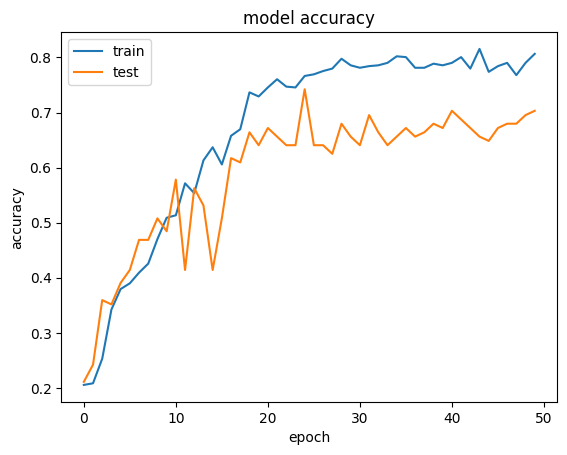

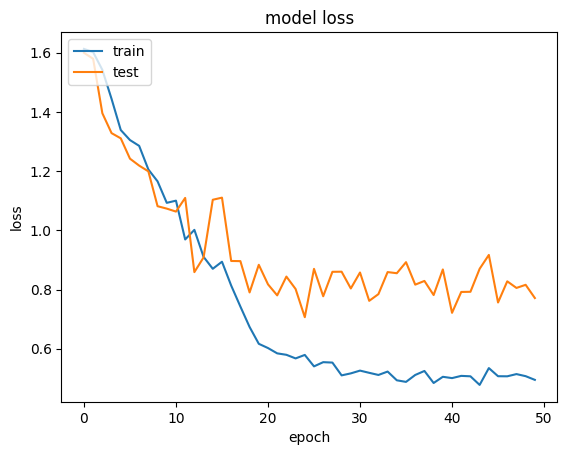

In [13]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULT:Training accuracy: 82.3%,Test ccuracy 70.3%**

**EXPERIMENT2 -> CONV3D +35EPOCHS 32BATCHSIZE + 160*160 13IMAGES**

In [26]:
batch_size= 32
dim_x,dim_y=160,160
num_epochs = 35

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu', input_shape=(13, dim_x, dim_y, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Second Convolution Layer
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Third Convolution Layer
model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Fourth Convolution Layer
model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))

# Use Global Pooling to avoid negative dimensions
model.add(GlobalMaxPooling3D())  # Pooling over all spatial dimensions

# Dropout Layer to prevent overfitting
model.add(Dropout(0.25))

# Flatten the feature maps
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 classes for classification



In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)              │ (None, 13, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 6, 80, 80, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 6, 80, 80, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 3, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 3, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 1, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 1, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling3d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling3D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,997 (1.18 MB)

 Trainable params: 308,997 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
from tensorflow.keras.callbacks import ReduceLROnPlateau
LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/35
19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - categorical_accuracy: 0.2080 - loss: 1.6203

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2061 - loss: 1.6199
Epoch 1: saving model to model_init_2024-12-0112_58_34.481153/model-00001-1.61674-0.18750-1.60128-0.21094.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - categorical_accuracy: 0.2052 - loss: 1.6198 - val_categorical_accuracy: 0.2109 - val_loss: 1.6013 - learning_rate: 0.0010
Epoch 2/35
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1912 - loss: 1.6076
Epoch 2: saving model to model_init_2024-12-0112_58_34.481153/model-00002-1.60336-0.20387-1.55348-0.23438.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - categorical_accuracy: 0.1918 - loss: 1.6074 - val_categorical_accuracy: 0.2344 - val_loss: 1.5535 - learning_rate: 0.0010
Epoch 3/35
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2327 - loss: 1.5611
Epoch 3: saving model to model_init_2024-12-0112_58_34.481153/model-00003-1.53111-0.28274-1.41200-0.39844.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - categorical_accuracy: 0

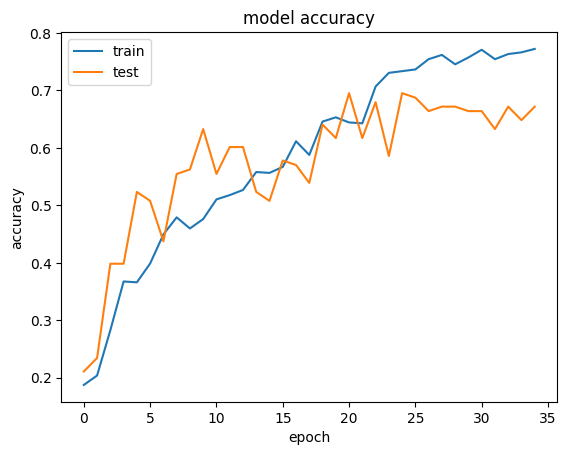

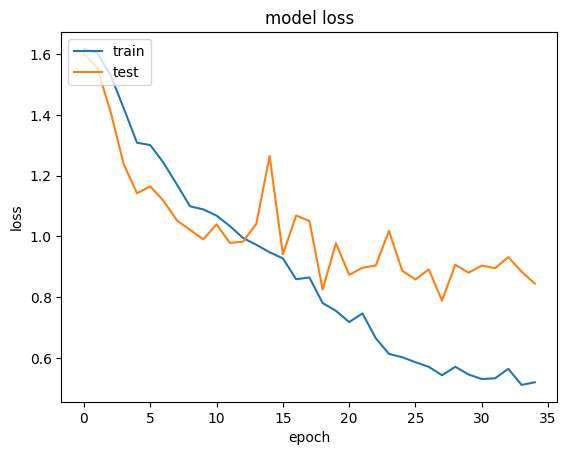

In [35]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULT:Training accuracy: 76.8%,Test ccuracy 67.1%**

****

**EXPERIMENT3 -> CONV3D +30EPOCHS 32BATCHSIZE + 120*120 13IMAGES + NORMALISATION**

In [52]:
batch_size= 32
dim_x,dim_y=120,120
num_epochs = 30

In [53]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, GlobalMaxPooling3D

model = Sequential()

# First Convolution Layer
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu', input_shape=(18, 120, 120, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Second Convolution Layer
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Third Convolution Layer
model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer


# Use Global Pooling to avoid negative dimensions
model.add(GlobalMaxPooling3D())  # Pooling over all spatial dimensions

# Dropout Layer to prevent overfitting
model.add(Dropout(0.25))

# Flatten the feature maps
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 classes for classification



In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 18, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 9, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 9, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling3d_5          │ (None, 64)             │             0 │
│ (GlobalMaxPooling3D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,493 (310.52 KB)

 Trainable params: 79,493 (310.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.2143 - loss: 1.6162

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2143 - loss: 1.6156
Epoch 1: saving model to model_init_2024-12-0114_37_45.782296/model-00001-1.60386-0.21429-1.55897-0.22656.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - categorical_accuracy: 0.2143 - loss: 1.6150 - val_categorical_accuracy: 0.2266 - val_loss: 1.5590 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2437 - loss: 1.5542
Epoch 2: saving model to model_init_2024-12-0114_37_45.782296/model-00002-1.52623-0.28274-1.38570-0.39062.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - categorical_accuracy: 0.2455 - loss: 1.5530 - val_categorical_accuracy: 0.3906 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3585 - loss: 1.4436
Epoch 3: saving model to model_init_2024-12-0114_37_45.782296/model-00003-1.41642-0.37649-1.26576-0.49219.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - categorical_accuracy: 0

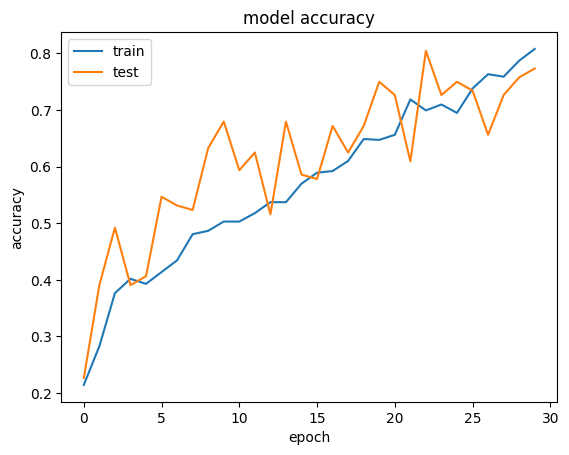

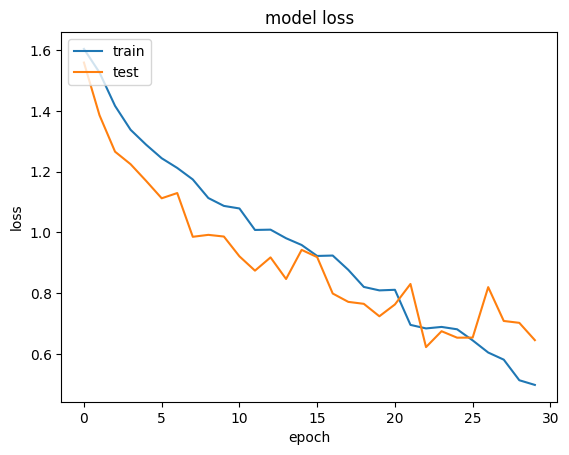

In [56]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULTS: Training Accuracy: 81.35% with a loss of 0.4860.
Validation Accuracy: 77.34% with a loss of 0.6456.**

**EXPERIEMENT4 -CONV2D 16BATCHSIZE, 35EPOCHS, 120*120 SIZE,**

In [55]:
batch_size= 16
dim_x,dim_y=120,120
num_epochs = 35

In [56]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, GlobalMaxPooling3D

model = Sequential()

# First Convolution Layer
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu', input_shape=(18, 120, 120, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer

# Second Convolution Layer
model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer


# Third Convolution Layer
model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling layer
model.add(BatchNormalization()) 

# Use Global Pooling to avoid negative dimensions
model.add(GlobalMaxPooling3D())  # Pooling over all spatial dimensions

# Dropout Layer to prevent overfitting
model.add(Dropout(0.4))

# Flatten the feature maps
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 classes for classification



In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_27 (Conv3D)              │ (None, 18, 120, 120,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 9, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_28 (Conv3D)              │ (None, 9, 60, 60, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 4, 30, 30, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_29 (MaxPooling3D) │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling3d_9          │ (None, 128)            │             0 │
│ (GlobalMaxPooling3D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,965 (1.13 MB)

 Trainable params: 296,709 (1.13 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/35
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - categorical_accuracy: 0.2503 - loss: 2.2225

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - categorical_accuracy: 0.2499 - loss: 2.2155
Epoch 1: saving model to model_init_2024-12-0116_08_26.970548/model-00001-1.92926-0.23065-1.60959-0.16964.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.2494 - loss: 2.2089 - val_categorical_accuracy: 0.1696 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 2/35
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - categorical_accuracy: 0.3088 - loss: 1.5271
Epoch 2: saving model to model_init_2024-12-0116_08_26.970548/model-00002-1.49980-0.31399-1.59249-0.16964.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 947ms/step - categorical_accuracy: 0.3089 - loss: 1.5265 - val_categorical_accuracy: 0.1696 - val_loss: 1.5925 - learning_rate: 0.0010
Epoch 3/35
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - categorical_accuracy: 0.4249 - loss: 1.3464
Epoch 3: saving model to model_init_2024-12-0116_08_26.970548/model-00003-1.36773-0.40327-1.55488-0.23214.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 883ms/step - categori

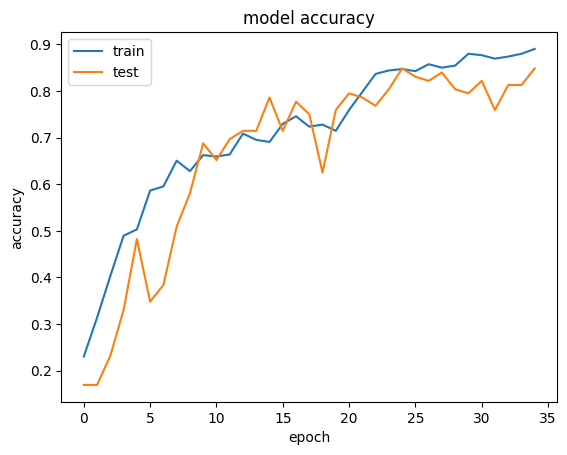

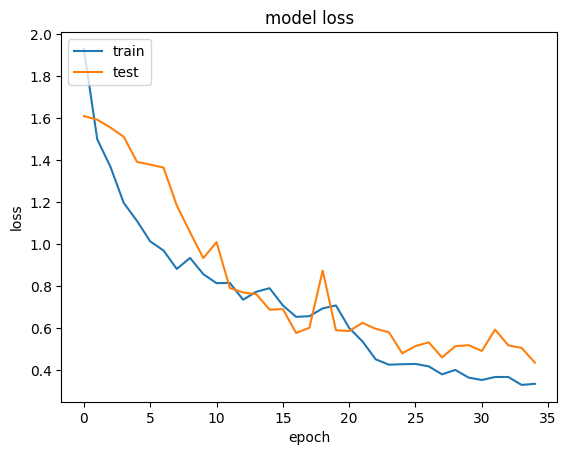

In [59]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULTS: Training Accuracy: 90.16% with a loss of 0.3019. Validation Accuracy: 84.82% with a loss of 0.4354.**

****

**EXPERIMENT5 -> CNN+LSTM->CNN+RNN**

In [6]:
model2=Sequential()

# First Convolution Layer
model2.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(13, 80, 80,3))))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))  # Pooling layer

# Second Convolution Layer
model2.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))  # Pooling layer

# Third Convolution Layer
model2.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))   # Pooling layer

# Fourth Convolution Layer
model2.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 

#Flatten
model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(128))
model2.add(Dropout(0.25))
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(5,activation='softmax'))
           
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [8]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [11]:
history=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)


/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - categorical_accuracy: 0.1943 - loss: 1.6649

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1948 - loss: 1.6634
Epoch 1: saving model to model_init_2024-12-0207_32_30.334020/model-00001-1.63374-0.20387-1.58960-0.21094.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - categorical_accuracy: 0.1952 - loss: 1.6620 - val_categorical_accuracy: 0.2109 - val_loss: 1.5896 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2654 - loss: 1.5838
Epoch 2: saving model to model_init_2024-12-0207_32_30.334020/model-00002-1.57907-0.27679-1.55128-0.30469.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - categorical_accuracy: 0.2659 - loss: 1.5836 - val_categorical_accuracy: 0.3047 - val_loss: 1.5513 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3550 - loss: 1.4769
Epoch 3: saving model to model_init_2024-12-0207_32_30.334020/model-00003-1.38691-0.40476-1.26126-0.51562.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - categorical_accuracy: 

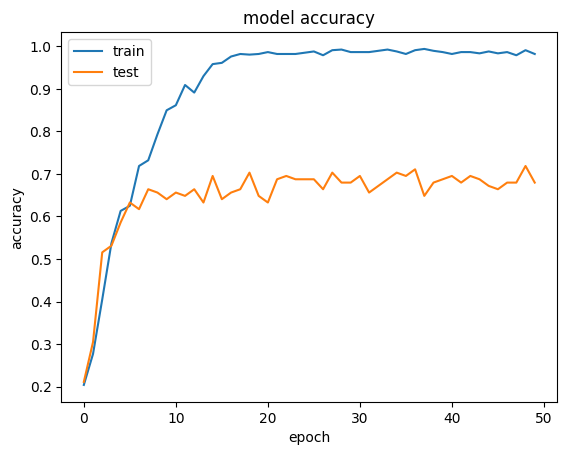

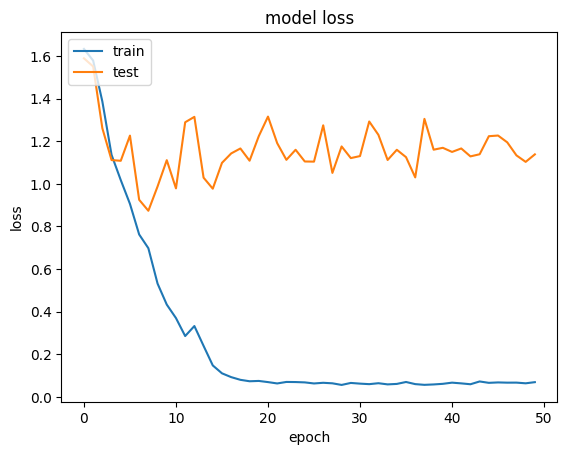

In [13]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULTS: Training accuracy: 98.16%,Test ccuracy 67.9%**

**EXPERIMENT6 -> CNN+RNN->CNN+GRU**

In [ ]:
model3=Sequential()

# First Convolution Layer
model3.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(13, 80, 80,3))))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))  # Pooling layer

# Second Convolution Layer
model3.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))  # Pooling layer

# Third Convolution Layer
model3.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))   # Pooling layer

# Fourth Convolution Layer
model3.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 

#Flatten
model3.add(TimeDistributed(Flatten()))
model3.add(GRU(128))
model3.add(Dropout(0.25))
model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(5,activation='softmax'))

In [15]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history=model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - categorical_accuracy: 0.3377 - loss: 1.6154

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3423 - loss: 1.6032
Epoch 1: saving model to model_init_2024-12-0207_32_30.334020/model-00001-1.47973-0.38988-2.09351-0.28906.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.3444 - loss: 1.5976 - val_categorical_accuracy: 0.2891 - val_loss: 2.0935 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5844 - loss: 1.1001
Epoch 2: saving model to model_init_2024-12-0207_32_30.334020/model-00002-1.07128-0.56845-1.27381-0.46875.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - categorical_accuracy: 0.5837 - loss: 1.0988 - val_categorical_accuracy: 0.4688 - val_loss: 1.2738 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6912 - loss: 0.8702
Epoch 3: saving model to model_init_2024-12-0207_32_30.334020/model-00003-0.84863-0.69196-0.98462-0.55469.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - categorical_accuracy: 0

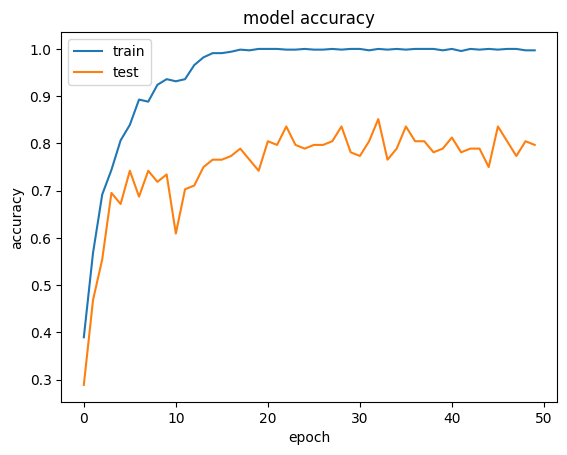

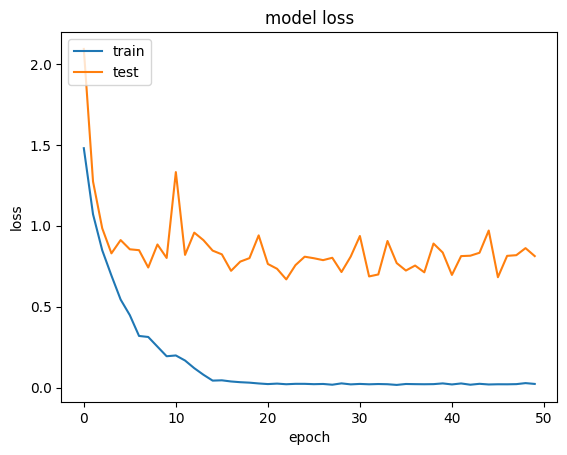

In [21]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULTS:TRAINING ACCURACY 99.81% TESTING ACCURACY 79.69%**

**EXPERIMENT7 -> TRANSFER LEARNING WITH GRU**

In [13]:
from keras.applications import ResNet50
ResNet_transfer=ResNet50(weights='imagenet',include_top=False)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model4=Sequential()
model4.add(TimeDistributed(ResNet_transfer,input_shape=(18, 120, 120,3)))
for layer in model4.layers[:-10]:
    layer.trainable=False
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
#Flatten
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(128))
model4.add(Dropout(0.4))
model4.add(Dense(128,activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(5,activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
history=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - categorical_accuracy: 0.2588 - loss: 1.8214 

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2688 - loss: 1.7970
Epoch 1: saving model to model_init_2024-12-0209_39_50.679456/model-00001-1.54901-0.37202-1.82128-0.23438.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - categorical_accuracy: 0.2735 - loss: 1.7857 - val_categorical_accuracy: 0.2344 - val_loss: 1.8213 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6230 - loss: 1.0180
Epoch 2: saving model to model_init_2024-12-0209_39_50.679456/model-00002-0.93943-0.65030-2.00737-0.14844.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - categorical_accuracy: 0.6242 - loss: 1.0144 - val_categorical_accuracy: 0.1484 - val_loss: 2.0074 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7392 - loss: 0.6664
Epoch 3: saving model to model_init_2024-12-0209_39_50.679456/model-00003-0.62842-0.76786-3.16348-0.25781.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - categorical_accuracy: 

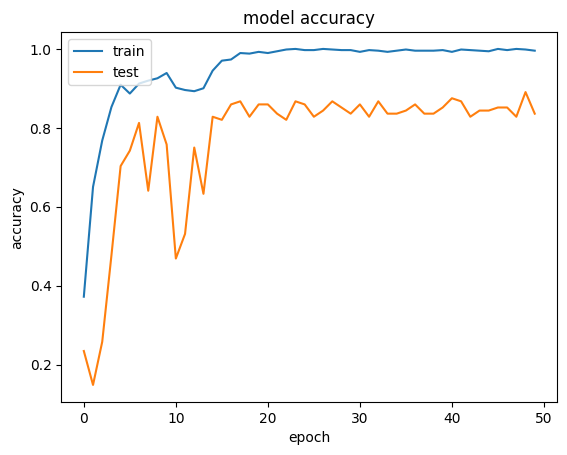

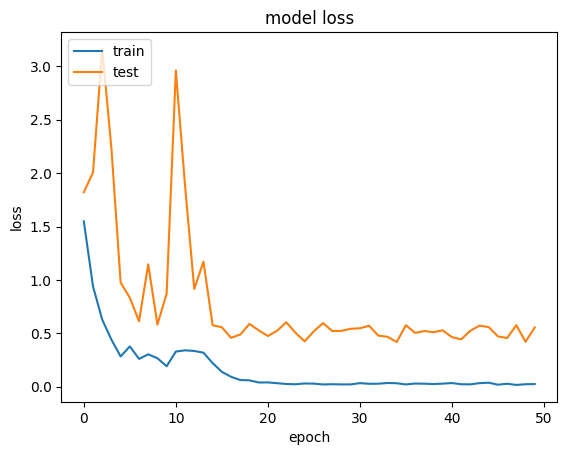

In [13]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**:RESULT:TRAINING ACCURACY 99.14% TESTING ACCURACY 83.59%**

****

**EXPERIMENT 8 TRANSFER LEARNING+LSTM**

In [11]:
batch_size= 32
num_epochs = 50

In [14]:
model5=Sequential()
model5.add(TimeDistributed(ResNet_transfer,input_shape=(18, 120, 120,3)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
#Flatten
model5.add(TimeDistributed(Flatten()))
model5.add(LSTM(128))
model5.add(Dropout(0.25))
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(5,activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR=ReduceLROnPlateau(monitor='val_loss',patience=5)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
history=model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_30/3970052492.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


Epoch 1/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - categorical_accuracy: 0.2571 - loss: 1.5953 

/tmp/ipykernel_30/3970052492.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path).astype(np.float32)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2631 - loss: 1.5881
Epoch 1: saving model to model_init_2024-12-0212_19_22.164162/model-00001-1.51033-0.32887-1.99119-0.20312.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - categorical_accuracy: 0.2661 - loss: 1.5846 - val_categorical_accuracy: 0.2031 - val_loss: 1.9912 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4629 - loss: 1.2880
Epoch 2: saving model to model_init_2024-12-0212_19_22.164162/model-00002-1.22011-0.48958-3.25529-0.22656.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - categorical_accuracy: 0.4642 - loss: 1.2849 - val_categorical_accuracy: 0.2266 - val_loss: 3.2553 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6161 - loss: 1.0372
Epoch 3: saving model to model_init_2024-12-0212_19_22.164162/model-00003-1.08188-0.58780-1.77386-0.23438.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - categorical_accuracy: 

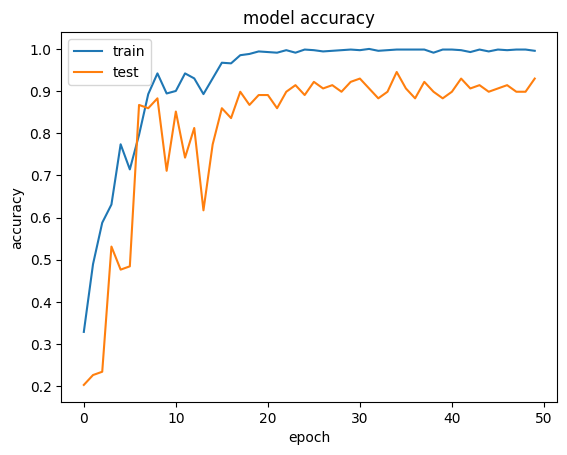

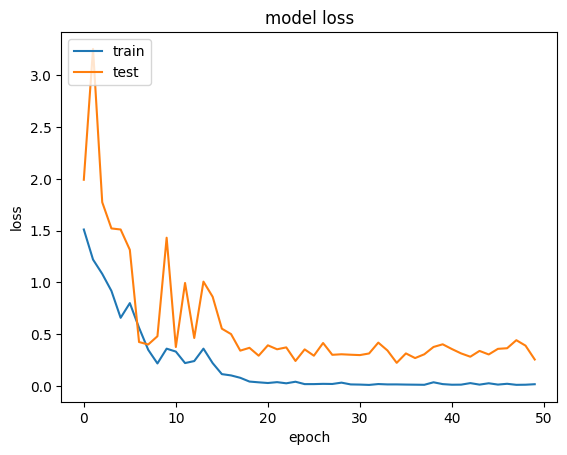

In [27]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULT:TRAINING ACCURACY 99.54% TESTING ACCURACY 86.72%******

In [28]:
!pip install h5py

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [30]:
from tensorflow.keras.models import load_model
model=model5.load_weights('model_init_2024-12-0212_19_22.164162/model-00050-0.01538-0.99554-0.25422-0.92969.keras')


In [33]:
model5.save('model.h5')